### General Steps
1. Crop svs file into slides of size_1 (2000 * 2000)
2. Crop size_1 slides into 80 * 80 pieces
3. Test the 80 * 80 pieces, output result, generate heatmap

In [19]:
import sys
import numpy as np
import pandas as pd
import glob
import os
import shutil
import tensorflow as tf
import seaborn as sns

from tqdm import *
from time import sleep

import re

from gi.repository import Vips

# gi.require_version('Vips', '8.0')
import matplotlib.pylab 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [2]:
im = Vips.Image.new_from_file('1002141-positive.svs')
print im.width, im.height

71619 30281


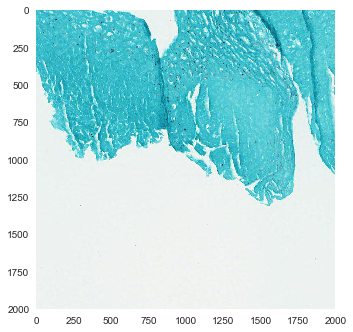

In [58]:
# decide size_1, size_1 = 2000
im_tmp2 = im.extract_area(46000, 13440, 2000, 2000)
im_tmp2.write_to_file('test.jpg')
img_tmp = plt.imread('test.jpg')
plt.grid('off')
plt.imshow(img_tmp)

In [ ]:
# Crop the orignal image into size_1 slides
for w in np.arange(0, im.width-1999, 2000):
    for h in np.arange(0, im.height-1999, 2000):
        im_tmp = im.extract_area(w, h, 2000, 2000)
        file_name = str(h/2000) + '_' + str(w/2000) + '.jpg'
        im_tmp.write_to_file('2000_slides/' + file_name)

### HeatMap matrix information
- heatmap matrix size 
- num_cols = im.width/2000/80  -- 34 * 25
- num_rows = im.height/2000/80 -- 14 * 25

### Size_1 slides steps
- Include the location info of each small pieces in the matrix to its name
- While training, also generate the heatmap matrix
- Output to excel

In [3]:
os.chdir('/Users/yiwenshi/Desktop/fungi_code/2000_slides/')
img_list = glob.glob('*.jpg')

In [4]:
# Define which model to use 
model_path = '/Users/yiwenshi/Desktop/v4_result/output_graph.pb'
label_path = '/Users/yiwenshi/Desktop/v4_result/output_labels.txt'

# Unpersists graph from file
with tf.gfile.FastGFile(model_path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
    
# Loads label file, strips off carriage return
label_lines = [line.rstrip() for line 
                   in tf.gfile.GFile(label_path)]    

In [5]:
img_list

['0_0.jpg',
 '0_1.jpg',
 '0_10.jpg',
 '0_11.jpg',
 '0_12.jpg',
 '0_13.jpg',
 '0_14.jpg',
 '0_15.jpg',
 '0_16.jpg',
 '0_17.jpg',
 '0_18.jpg',
 '0_19.jpg',
 '0_2.jpg',
 '0_20.jpg',
 '0_21.jpg',
 '0_22.jpg',
 '0_23.jpg',
 '0_24.jpg',
 '0_25.jpg',
 '0_26.jpg',
 '0_27.jpg',
 '0_28.jpg',
 '0_29.jpg',
 '0_3.jpg',
 '0_30.jpg',
 '0_31.jpg',
 '0_32.jpg',
 '0_33.jpg',
 '0_34.jpg',
 '0_4.jpg',
 '0_5.jpg',
 '0_6.jpg',
 '0_7.jpg',
 '0_8.jpg',
 '0_9.jpg',
 '10_0.jpg',
 '10_1.jpg',
 '10_10.jpg',
 '10_11.jpg',
 '10_12.jpg',
 '10_13.jpg',
 '10_14.jpg',
 '10_15.jpg',
 '10_16.jpg',
 '10_17.jpg',
 '10_18.jpg',
 '10_19.jpg',
 '10_2.jpg',
 '10_20.jpg',
 '10_21.jpg',
 '10_22.jpg',
 '10_23.jpg',
 '10_24.jpg',
 '10_25.jpg',
 '10_26.jpg',
 '10_27.jpg',
 '10_28.jpg',
 '10_29.jpg',
 '10_3.jpg',
 '10_30.jpg',
 '10_31.jpg',
 '10_32.jpg',
 '10_33.jpg',
 '10_34.jpg',
 '10_4.jpg',
 '10_5.jpg',
 '10_6.jpg',
 '10_7.jpg',
 '10_8.jpg',
 '10_9.jpg',
 '11_0.jpg',
 '11_1.jpg',
 '11_10.jpg',
 '11_11.jpg',
 '11_12.jpg',
 '11_13

In [6]:
for img in ['1_25.jpg', '1_26.jpg', '2_25.jpg', '2_26.jpg', '1_27.jpg', '2_27.jpg']:
    # name of current image to be processed, without extension
    img_name = img[:-4]
    print img
    
    # check if folder for specific size_1 image exists, and make sure of the contents
    if not os.path.exists(img_name):
        # no folders for this img, create folder and crop into 80 * 80
        os.makedirs(img_name)
        
        # Crop the orignal image into 80 * 80 slides
        im1 = Vips.Image.new_from_file(img)
        for w in np.arange(0, 2000-79, 80):
            for h in np.arange(0, 2000-79, 80):
                im_tmp = im1.extract_area(w, h, 80, 80)
                file_name = img_name + '_' + str(h/80) + '_' + str(w/80) + '.jpg'
                im_tmp.write_to_file(img_name + '/' + file_name)
    else:
        # if folder exists
        imgs = glob.glob(img_name + '/*.jpg')
        
        if len(imgs) != 625:
            # check if the number of images is not correct
            shutil.rmtree(img_name)
            os.makedirs(img_name)
            # Crop the orignal image into 80 * 80 slides
            im1 = Vips.Image.new_from_file(img)
            for w in np.arange(0, 2000-79, 80):
                for h in np.arange(0, 2000-79, 80):
                    im_tmp = im1.extract_area(w, h, 80, 80)
                    file_name = img_name + '_' + str(h/80) + '_' + str(w/80) + '.jpg'
                    im_tmp.write_to_file(img_name + '/' + file_name)
    
    # test the current set of images 
    sub_imgs = glob.glob(os.getcwd() + '/' + img_name + '/*.jpg')

    result = pd.DataFrame(columns=['path', 'score'] + label_lines)
    for idx in tqdm(range(len(sub_imgs))):
        image_path = sub_imgs[idx]
#     for image_path in sub_imgs:
        image_data = tf.gfile.FastGFile(image_path, 'rb').read()
        image_name = image_path[image_path.rfind('/')+1:]
#         print image_name
        with tf.Session() as sess:
            # Feed the image_data as input to the graph and get first prediction
            softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
            predictions = sess.run(softmax_tensor, \
                     {'DecodeJpeg/contents:0': image_data})
            tmp = pd.DataFrame(predictions, columns=label_lines)
            tmp['path'] = image_name
            tmp['score'] = tmp['fungi'] + tmp['suspicious']
            result = result.append(tmp, ignore_index=True)
    result_name = img_name + '/' + img_name + '.csv'
    result.to_csv(result_name, index=False)
    


1_25.jpg


100%|██████████| 625/625 [19:16<00:00,  1.84s/it]


1_26.jpg


100%|██████████| 625/625 [21:27<00:00,  1.90s/it]


2_25.jpg


100%|██████████| 625/625 [18:53<00:00,  1.77s/it]


2_26.jpg


100%|██████████| 625/625 [24:48<00:00,  1.90s/it]  


1_27.jpg


100%|██████████| 625/625 [19:49<00:00,  1.92s/it]


2_27.jpg


100%|██████████| 625/625 [20:02<00:00,  1.85s/it]


### Extract output data and plot HeatMap

80 * 80 Image name: h1_w1_h2_w2.jpg

- h1: The row info of this size_1 image in the original image
- w1: The col info of this size_1 image in the original image
- h2: The row info of the 80 * 80 image in the size_1 image
- w2: The col info of the 80 * 80 image in the size_1 image

#### Steps
1. Decide neighboring regions to plot
2. Retrive output data, calculate the heatmap matrix
3. Plot the heatmap

In [7]:
os.chdir('/Users/yiwenshi/Desktop/fungi_code/2000_slides/')

Following is just an example, uses the following images to plot the heatmap

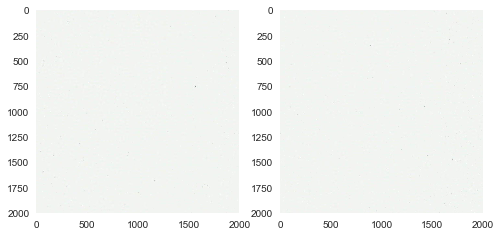

In [61]:
im1 = plt.imread('0_0.jpg')
im2 = plt.imread('0_1.jpg')
fig = plt.figure()
a=fig.add_subplot(1,2,1)
plt.grid('off')
plt.imshow(im1)
a=fig.add_subplot(1,2,2)
plt.grid('off')
plt.imshow(im2)


#### Decide the region of images to be ploted

In [10]:
# images to be ploted, provide the top left and bottom right one
imgs_plot = ['1_25.jpg', '2_27.jpg']

# parse image names into matrix, and calculate matrix size
width_idx = []
height_idx = []
for tmp in imgs_plot:
    [h, w, _] = re.split('\\_|\\.', tmp)
    width_idx.append(int(w))
    height_idx.append(int(h))
width_idx = range(min(width_idx), max(width_idx)+1)
height_idx = range(min(height_idx), max(height_idx)+1)
width_range = (max(width_idx) - min(width_idx) + 1) * (2000 / 80)
height_range = (max(height_idx) - min(height_idx) + 1) * (2000 / 80)

In [15]:
print width_idx, height_idx, width_range, height_range

[25, 26, 27] [1, 2] 75 50


#### Read output data and fill in the matrix

In [13]:
# first check if all required data exists
for h in height_idx:
    for w in width_idx:
        # img_name = h_w.jpg
        f_name = str(h) + '_' + str(w) + '/' + str(h) + '_' + str(w) + '.csv'
        print f_name
        if os.path.isfile(f_name):
            pass
        else:
            raise ValueError('File ' + f_name + ' does not exist! Incomplete data for Heatmap! \n')
print 'Data check complete! '            

1_25/1_25.csv
1_26/1_26.csv
1_27/1_27.csv
2_25/2_25.csv
2_26/2_26.csv
2_27/2_27.csv
Data check complete! 


In [17]:
# read data into matrix
# create the zero matrix
heat_mat = np.zeros((height_range, width_range))

for h in height_idx:
    for w in width_idx:
        # img_name = h_w.jpg
        f_name = str(h) + '_' + str(w) + '/' + str(h) + '_' + str(w) + '.csv'
        tmp = pd.read_csv(f_name)
        for i in range(len(tmp)):
            tmp_name = tmp['path'][i]
            [h1, w1, h2, w2, _] = re.split('\\_|\\.', tmp_name)
#             print int(h1), int(w1), int(h2), int(w2)
            h_mat = (int(h1) - min(height_idx)) * (2000/80) + int(h2)
            w_mat = (int(w1) - min(width_idx)) * (2000/80) + int(w2)
            heat_mat[h_mat, w_mat] = tmp['score'][i]

(0.0, 75.0, 0.0, 50.0)

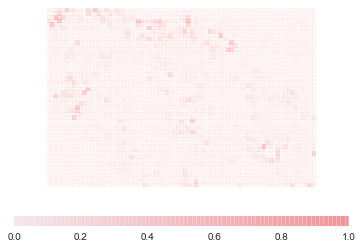

In [43]:
fig = plt.figure(figsize=(20,20))
# cmap = sns.blend_palette(['#a0db8e', '#fff68f', '#ff4040'], n_colors=3, as_cmap=True, input="rgb")
cmap = sns.light_palette("#ff4040", as_cmap=True)

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(heat_mat, ax=ax, vmin=0, vmax=1, square=True, cbar=True, cmap=cmap,alpha=0.3,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})
ax.axis('off')